<a href="https://colab.research.google.com/github/piru24/DL_LABS-07/blob/main/Gridworld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The agent-environment interaction

In this exercise, you will implement the interaction of a reinforecment learning agent with its environment. We will use the gridworld environment from the second lecture. You will find a description of the environment below, along with two pieces of relevant material from the lectures: the agent-environment interface and the Q-learning algorithm.

1. Create an agent that chooses actions randomly with this environment.

2. Create an agent that uses Q-learning. You can use initial Q values of 0, a stochasticity parameter for the $\epsilon$-greedy policy function $\epsilon=0.05$, and a learning rate $\alpha = 0.1$. But feel free to experiment with other settings of these three parameters.

3. Plot the mean total reward obtained by the two agents through the episodes. This is called a **learning curve**. Run enough episodes for the Q-learning agent to converge to a near-optimal policy.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## The agent-environment interface

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/agent-environment.png" style="width: 500px;" align="left"/>

<br><br><br>

The interaction of the agent with its environments starts at decision stage $t=0$ with the observation of the current state $s_0$. (Notice that there is no reward at this initial stage.) The agent then chooses an action to execute at decision stage $t=1$. The environment responds by changing its state to $s_1$ and returning the numerical reward signal $r_1$.


## The environment: Navigation in a gridworld

<img src="https://raw.githubusercontent.com/dkasthurirathna/dl/master/gold.png" style="width: 250px;" align="left"/>

The agent has four possible actions in each state (grid square): west, north, south, and east. The actions are unreliable. They move the agent in the intended direction with probability 0.8, and with probability 0.2, they move the agent in a random other direction. It the direction of movement is blocked, the agent remains in the same grid square. The initial state of the agent is one of the five grid squares at the bottom, selected randomly. The grid squares with the gold and the bomb are **terminal states**. If the agent finds itself in one of these squares, the episode ends. Then a new episode begins with the agent at the initial state.

You will use a reinforcement learning algorithm to compute the best policy for finding the gold with as few steps as possible while avoiding the bomb. For this, we will use the following reward function: $-1$ for each navigation action, an additional $+10$ for finding the gold, and an additional $-10$ for hitting the bomb. For example, the immediate reward for transitioning into the square with the gold is $-1 + 10 = +9$. Do not use discounting (that is, set $\gamma=1$).

## Q-learning

![title](https://raw.githubusercontent.com/dkasthurirathna/dl/master/q.png)
From Sutton & Barto (1998), Reinforcement Learning.

In [ ]:
import numpy as np
import operator
import matplotlib.pyplot as plt
%matplotlib inline

# Classes for the Enviroment and the Agent

- The GridWorld class contains the environment
- The dimensions of the environment are defined
- Locations of all rewards are stored
- Functions for different methods written
    - `get_available_actions` returns possible actions
    - `agent_on_map` prints out current location of the agent on the grid (used for debugging)
    - `get_reward` returns the reward for an input position
    - `make_step` moves the agent in a specified direction

In [ ]:
class GridWorld:
    ## Initialise starting data
    def __init__(self):
        # Set information about the gridworld
        self.height = 8
        self.width = 8
        self.grid = np.zeros(( self.height, self.width)) - 1

        # Set random start location for the agent
        self.current_location = ( 4, np.random.randint(0,5))

        # Set locations for the bomb and the gold
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [ self.bomb_location, self.gold_location]

        # Set grid rewards for special cells
        self.grid[ self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[ self.gold_location[0], self.gold_location[1]] = 10

        # Set available actions
        self.actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']


    ## Put methods here:
    def get_available_actions(self):
        """Returns possible actions"""
        return self.actions

    def agent_on_map(self):
        """Prints out current location of the agent on the grid (used for debugging)"""
        grid = np.zeros(( self.height, self.width))
        grid[ self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, new_location):
        """Returns the reward for an input position"""
        return self.grid[ new_location[0], new_location[1]]


    def make_step(self, action):
        """Moves the agent in the specified direction. If agent is at a border, agent stays still
        but takes negative reward. Function returns the reward for the move."""
        # Store previous location
        last_location = self.current_location

        # UP
        if action == 'UP':
            # If agent is at the top, stay still, collect reward
            if last_location[0] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] - 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # DOWN
        elif action == 'DOWN':
            # If agent is at bottom, stay still, collect reward
            if last_location[0] == self.height - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0] + 1, self.current_location[1])
                reward = self.get_reward(self.current_location)

        # LEFT
        elif action == 'LEFT':
            # If agent is at the left, stay still, collect reward
            if last_location[1] == 0:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] - 1)
                reward = self.get_reward(self.current_location)

        # RIGHT
        elif action == 'RIGHT':
            # If agent is at the right, stay still, collect reward
            if last_location[1] == self.width - 1:
                reward = self.get_reward(last_location)
            else:
                self.current_location = ( self.current_location[0], self.current_location[1] + 1)
                reward = self.get_reward(self.current_location)

        return reward

    def check_state(self):
        """Check if the agent is in a terminal state (gold or bomb), if so return 'TERMINAL'"""
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

In [ ]:
class RandomAgent():
    # Choose a random action
    def choose_action(self, available_actions):
        """Returns a random choice of the available actions"""
        return np.random.choice(available_actions)

In [ ]:
class Q_Agent():
    # Intialise
    def __init__(self, environment, epsilon=0.05, alpha=0.1, gamma=1):
        self.environment = environment
        self.q_table = dict()
        for x in range(environment.height):
            for y in range(environment.width):
                self.q_table[(x,y)] = {'UP':0, 'DOWN':0, 'LEFT':0, 'RIGHT':0}

        self.epsilon = epsilon
        self.alpha = alpha
        self.gamma = gamma

    def choose_action(self, available_actions):
        """Epsilon-greedy action selection"""
        state = self.environment.current_location

        if np.random.uniform(0,1) < self.epsilon:
            # Exploration: choose random action
            action = np.random.choice(available_actions)
        else:
            # Exploitation: choose best action from Q-table
            q_values = self.q_table[state]
            max_q = max(q_values.values())
            best_actions = [a for a, q in q_values.items() if q == max_q]
            action = np.random.choice(best_actions)

        return action

    def learn(self, old_state, reward, new_state, action):
        """Q-learning update rule"""
        old_q = self.q_table[old_state][action]
        next_max_q = max(self.q_table[new_state].values())

        # Bellman update
        new_q = old_q + self.alpha * (reward + self.gamma * next_max_q - old_q)
        self.q_table[old_state][action] = new_q


In [ ]:
def play(environment, agent, trials=500, max_steps_per_episode=1000, learn=False):
    """The play function runs iterations and updates Q-values if desired."""
    reward_per_episode = [] # Initialise performance log

    for trial in range(trials): # Run trials
        cumulative_reward = 0 # Initialise values of each game
        step = 0
        game_over = False
        while step < max_steps_per_episode and game_over != True: # Run until max steps or until game is finished
            old_state = environment.current_location
            action = agent.choose_action(environment.actions)
            reward = environment.make_step(action)
            new_state = environment.current_location

            if learn == True: # Update Q-values if learning is specified
                agent.learn(old_state, reward, new_state, action)

            cumulative_reward += reward
            step += 1

            if environment.check_state() == 'TERMINAL': # If game is in terminal state, game over and start next trial
                environment.__init__()
                game_over = True

        reward_per_episode.append(cumulative_reward) # Append reward for current trial to performance log

    return reward_per_episode # Return performance log

## Run Random Agent

- Random agent moves randomly and does not learn from it's actions.
- This gives a base performance to compare the Q-Learning agent to

In [ ]:
env = GridWorld()
agent = RandomAgent()

print("Current position of the agent =", env.current_location)
print(env.agent_on_map())
available_actions = env.get_available_actions()
print("Available_actions =", available_actions)
chosen_action = agent.choose_action(available_actions)
print("Randomly chosen action =", chosen_action)
reward = env.make_step(chosen_action)
print("Reward obtained =", reward)
print("Current position of the agent =", env.current_location)
print(env.agent_on_map())

Current position of the agent = (4, 4)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]
Available_actions = ['UP', 'DOWN', 'LEFT', 'RIGHT']
Randomly chosen action = LEFT
Reward obtained = -1.0
Current position of the agent = (4, 3)
[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


- Here the random agent is ran for 500 trials
- Performance is obviously inconsistent and not optimal

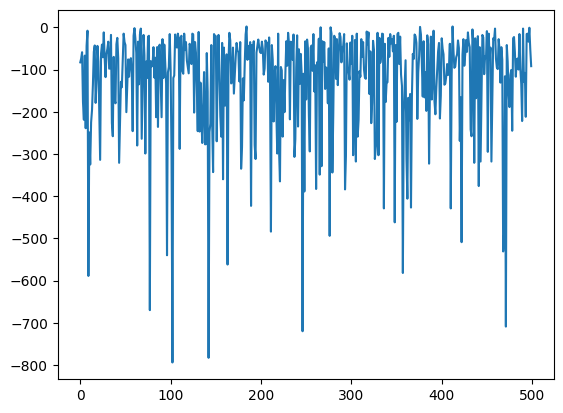

In [ ]:
# Initialize environment and agent
environment = GridWorld()
random_agent = RandomAgent()

reward_per_episode = play(environment, random_agent, trials=500)

# Simple learning curve
plt.plot(reward_per_episode)

## Q-Agent

- Here the Q-Learning agent is ran for 500 trials again
- Performance is plotted
- Performance increases greatly

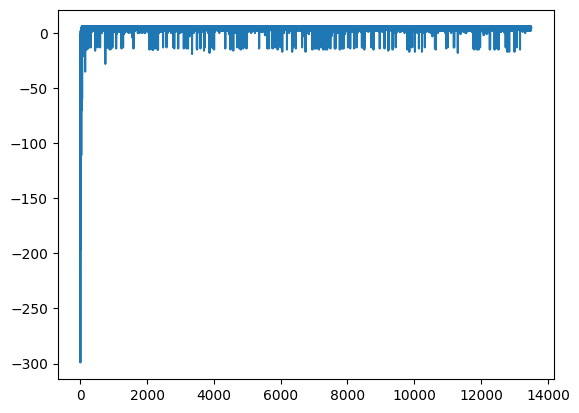

In [ ]:
environment = GridWorld()
agentQ = Q_Agent(environment)

# Note the learn=True argument!
reward_per_episode = play(environment, agentQ, trials=13500, learn=True)

# Simple learning curve
plt.plot(reward_per_episode)

Print the final Q-value table with nice formatting.

In [ ]:
def pretty(d, indent=0):
    for key, value in d.items():
        print('\t' * indent + str(key))
        if isinstance(value, dict):
            pretty(value, indent+1)
        else:
            print('\t' * (indent+1) + str(value))


pretty(agentQ.q_table)

(0, 0)
	UP
		-0.38340184023094553
	DOWN
		-0.31799999999999995
	LEFT
		-0.30000000000000004
	RIGHT
		1.4111805336786585
(0, 1)
	UP
		0.6172825835449671
	DOWN
		-0.11000000000000001
	LEFT
		-0.22325007274224226
	RIGHT
		8.999998490929322
(0, 2)
	UP
		8.99999906325168
	DOWN
		7.999992669422146
	LEFT
		7.999972509714473
	RIGHT
		9.999999999999993
(0, 3)
	UP
		0
	DOWN
		0
	LEFT
		0
	RIGHT
		0
(0, 4)
	UP
		8.30856078875271
	DOWN
		7.68465185732757
	LEFT
		9.999999999999993
	RIGHT
		6.509713046293623
(0, 5)
	UP
		0.30671697290162764
	DOWN
		-0.218
	LEFT
		8.657208878628355
	RIGHT
		-0.31000000000000005
(0, 6)
	UP
		-0.4
	DOWN
		-0.41729000000000005
	LEFT
		0.1764779729016276
	RIGHT
		-0.40909000000000006
(0, 7)
	UP
		-0.4
	DOWN
		-0.5018100000000001
	LEFT
		-0.4809
	RIGHT
		-0.4
(1, 0)
	UP
		-0.5257319690000001
	DOWN
		-0.548
	LEFT
		-0.5
	RIGHT
		0.9458819009412848
(1, 1)
	UP
		0.5556468115202571
	DOWN
		0.2996520209475778
	LEFT
		-0.4637485879839996
	RIGHT
		7.999994218570778
(1, 2)
	UP
		

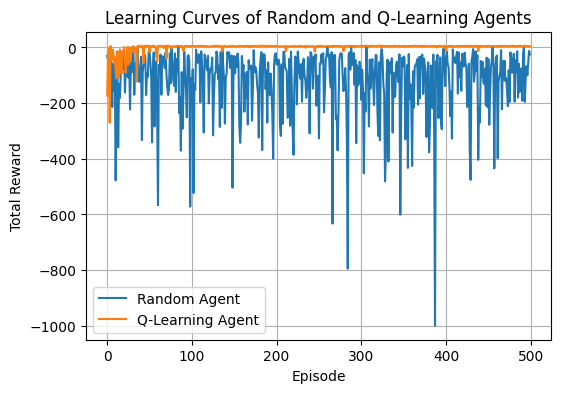

In [ ]:
# Run random agent and get rewards
environment_random = GridWorld()
random_agent = RandomAgent()
reward_per_episode_random = play(environment_random, random_agent, trials=500)

# Run Q-learning agent and get rewards
environment_q = GridWorld()
agentQ = Q_Agent(environment_q)
reward_per_episode_q = play(environment_q, agentQ, trials=500, learn=True)

# Plot learning curves
plt.figure(figsize=(6, 4))
plt.plot(reward_per_episode_random, label='Random Agent')
plt.plot(reward_per_episode_q, label='Q-Learning Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves of Random and Q-Learning Agents')
plt.legend()
plt.grid(True)
plt.show()

Saving Screenshot 2025-09-28 084716.png to Screenshot 2025-09-28 084716.png


(np.float64(-0.5), np.float64(963.5), np.float64(490.5), np.float64(-0.5))

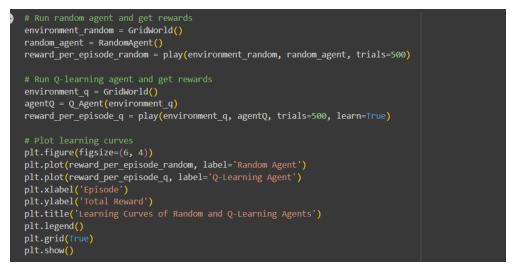

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload file
uploaded = files.upload()

# Display the uploaded image
image_name = list(uploaded.keys())[0]
img = Image.open(image_name)
plt.imshow(img)
plt.axis('off')

Saving Screenshot 2025-09-28 084723.png to Screenshot 2025-09-28 084723.png


(np.float64(-0.5), np.float64(895.5), np.float64(513.5), np.float64(-0.5))

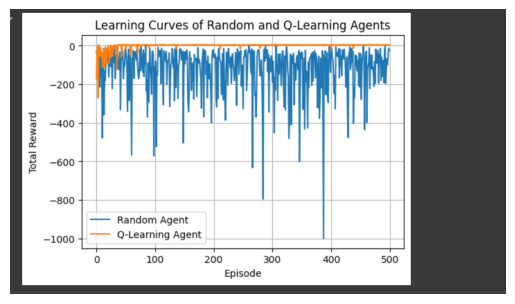

In [ ]:
from google.colab import files
from PIL import Image
import matplotlib.pyplot as plt

# Upload file
uploaded = files.upload()

# Display the uploaded image
image_name = list(uploaded.keys())[0]
img = Image.open(image_name)
plt.imshow(img)
plt.axis('off')

Q-Learning took 0.2736 seconds
Random Agent took 1.0968 seconds


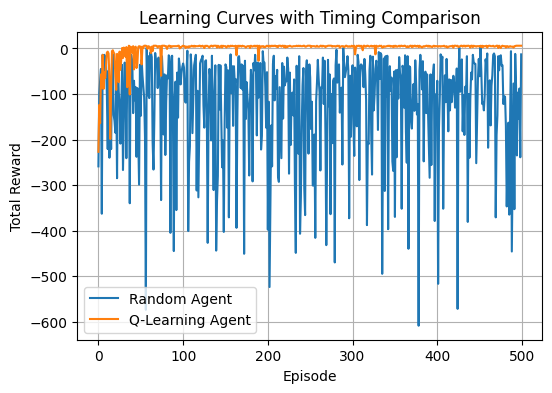

In [ ]:
import time

# Q-Learning Agent Timing
env_q = GridWorld()
agent_q = Q_Agent(env_q)

start_time = time.time()
reward_per_episode_q = play(env_q, agent_q, trials=500, learn=True)
elapsed_time_q = time.time() - start_time
print(f"Q-Learning took {elapsed_time_q:.4f} seconds")

# Random Agent Timing
env_random = GridWorld()
random_agent = RandomAgent()

start_time = time.time()
reward_per_episode_random = play(env_random, random_agent, trials=500, learn=False)
elapsed_time_random = time.time() - start_time
print(f"Random Agent took {elapsed_time_random:.4f} seconds")

# Compare learning curves
plt.figure(figsize=(6, 4))
plt.plot(reward_per_episode_random, label='Random Agent')
plt.plot(reward_per_episode_q, label='Q-Learning Agent')
plt.xlabel('Episode')
plt.ylabel('Total Reward')
plt.title('Learning Curves with Timing Comparison')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
!pip install torch --quiet

# Imports
import numpy as np
import random
import matplotlib.pyplot as plt
from collections import deque
import torch
import torch.nn as nn
import torch.optim as optim
%matplotlib inline

In [ ]:
class GridWorld:
    def __init__(self, stochastic=True):
        self.height = 8
        self.width = 8
        self.grid = np.zeros((self.height, self.width)) - 1
        self.current_location = (4, np.random.randint(0,5))
        self.bomb_location = (1,3)
        self.gold_location = (0,3)
        self.terminal_states = [self.bomb_location, self.gold_location]
        self.grid[self.bomb_location[0], self.bomb_location[1]] = -10
        self.grid[self.gold_location[0], self.gold_location[1]] = 10
        self.actions = ['UP','DOWN','LEFT','RIGHT']
        self.stochastic = stochastic

    def get_available_actions(self):
        return self.actions

    def agent_on_map(self):
        grid = np.zeros((self.height, self.width))
        grid[self.current_location[0], self.current_location[1]] = 1
        return grid

    def get_reward(self, loc):
        return self.grid[loc[0], loc[1]]

    def _move(self, action):
        last_location = self.current_location
        if action == 'UP':
            if last_location[0] == 0:
                return last_location
            return (last_location[0]-1, last_location[1])
        elif action == 'DOWN':
            if last_location[0] == self.height-1:
                return last_location
            return (last_location[0]+1, last_location[1])
        elif action == 'LEFT':
            if last_location[1] == 0:
                return last_location
            return (last_location[0], last_location[1]-1)
        elif action == 'RIGHT':
            if last_location[1] == self.width-1:
                return last_location
            return (last_location[0], last_location[1]+1)
        return last_location

    def make_step(self, action):
        # stochasticity: 0.8 execute chosen action, 0.2 choose different random
        if self.stochastic:
            if random.random() < 0.8:
                chosen = action
            else:
                other = [a for a in self.actions if a != action]
                chosen = random.choice(other)
        else:
            chosen = action

        new_loc = self._move(chosen)
        self.current_location = new_loc
        return self.get_reward(new_loc)

    def check_state(self):
        if self.current_location in self.terminal_states:
            return 'TERMINAL'

    def reset(self):
        self.current_location = (4, np.random.randint(0,5))
        return self.current_location

In [ ]:
class DQN(nn.Module):
    def __init__(self, state_dim=2, action_dim=4):
        super(DQN, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, action_dim)
        )
    def forward(self, x):
        return self.net(x)

# Helper: state encoding (normalize coordinates)
def encode_state(loc, env):
    # (row, col) -> normalized floats
    return np.array([loc[0] / (env.height-1), loc[1] / (env.width-1)], dtype=np.float32)

# Epsilon-greedy action selection
def select_action(policy_net, state_vec, epsilon):
    if random.random() < epsilon:
        return random.randrange(4)
    else:
        with torch.no_grad():
            s = torch.from_numpy(state_vec).unsqueeze(0)
            q = policy_net(s)
            return int(q.argmax().item())

# Single-step update (online, no replay, for Q1)
def dqn_update(policy_net, optimizer, state_vec, action, reward, next_state_vec, done, gamma=1.0):
    policy_net.train()
    state = torch.from_numpy(state_vec).unsqueeze(0)
    next_state = torch.from_numpy(next_state_vec).unsqueeze(0)
    q_values = policy_net(state)
    q_value = q_values[0, action]

    with torch.no_grad():
        next_q = policy_net(next_state)
        max_next = next_q.max(1)[0].item()
        target = reward + gamma * max_next * (0 if done else 1)

    target_t = torch.tensor([target], dtype=torch.float32)
    loss = nn.functional.mse_loss(q_value, target_t)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

In [ ]:
def train_grid_dqn(epsilon, episodes=2000, max_steps=200):
    env = GridWorld(stochastic=True)
    policy_net = DQN()
    optimizer = optim.Adam(policy_net.parameters(), lr=1e-3)
    gamma = 1.0

    rewards = []
    losses = []

    for ep in range(episodes):
        env.reset()
        total_reward = 0
        done = False
        steps = 0
        while not done and steps < max_steps:
            s = env.current_location
            s_vec = encode_state(s, env)
            a_idx = select_action(policy_net, s_vec, epsilon)
            action = env.actions[a_idx]
            r = env.make_step(action)
            ns = env.current_location
            done = (env.check_state() == 'TERMINAL')
            ns_vec = encode_state(ns, env)
            total_reward += r

            loss_val = dqn_update(policy_net, optimizer, s_vec, a_idx, r, ns_vec, done, gamma)
            losses.append(loss_val)
            steps += 1

            if done:
                # reset env for next episode
                break

        rewards.append(total_reward)

    return rewards, losses

Training GridWorld DQN with epsilon = 0.1


/tmp/ipython-input-1672051937.py:43: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.mse_loss(q_value, target_t)


Training GridWorld DQN with epsilon = 0.5
Training GridWorld DQN with epsilon = 0.9


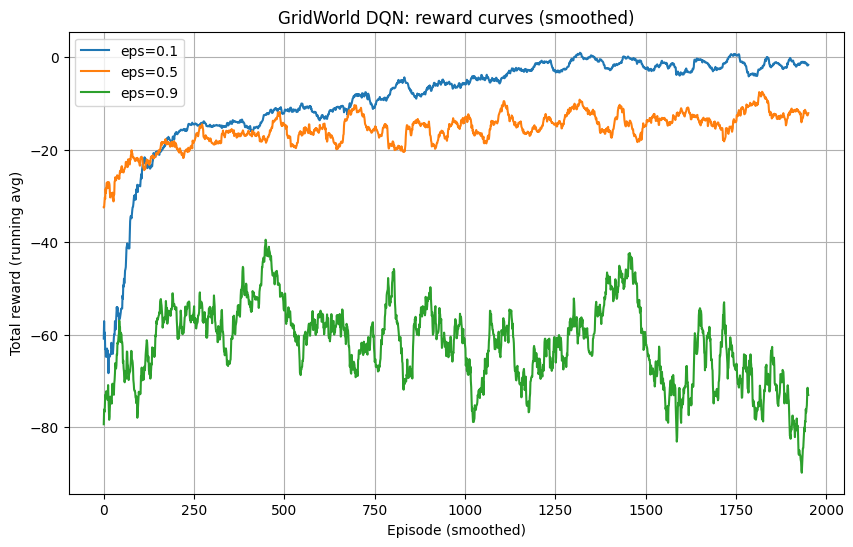

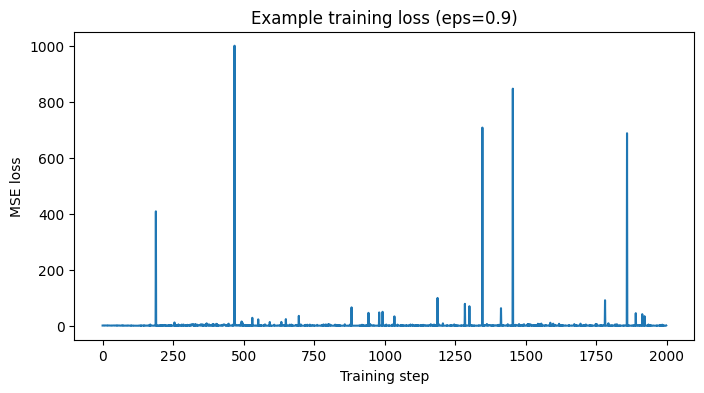

Saved plots: gridworld_dqn_eps_comparison.png and gridworld_dqn_loss_example.png


In [ ]:
eps_list = [0.1, 0.5, 0.9]
results = {}
for eps in eps_list:
    print("Training GridWorld DQN with epsilon =", eps)
    rewards, losses = train_grid_dqn(epsilon=eps, episodes=2000, max_steps=200)
    results[eps] = {'rewards': rewards, 'losses': losses}

# Plot reward curves (smoothed)
plt.figure(figsize=(10,6))
for eps in eps_list:
    r = results[eps]['rewards']
    # smoothing using running average
    window = 50
    smoothed = np.convolve(r, np.ones(window)/window, mode='valid')
    plt.plot(np.arange(len(smoothed)), smoothed, label=f"eps={eps}")
plt.xlabel("Episode (smoothed)")
plt.ylabel("Total reward (running avg)")
plt.title("GridWorld DQN: reward curves (smoothed)")
plt.legend()
plt.grid(True)
plt.savefig("gridworld_dqn_eps_comparison.png", dpi=150)
plt.show()

# Save losses plot (for last epsilon)
plt.figure(figsize=(8,4))
plt.plot(results[eps_list[-1]]['losses'][:2000])
plt.xlabel("Training step")
plt.ylabel("MSE loss")
plt.title(f"Example training loss (eps={eps_list[-1]})")
plt.savefig("gridworld_dqn_loss_example.png", dpi=150)
plt.show()

print("Saved plots: gridworld_dqn_eps_comparison.png and gridworld_dqn_loss_example.png")

In [ ]:
%%bash
pip3 install gymnasium[classic_control]

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [ ]:
import random, math, time
import numpy as np
import matplotlib.pyplot as plt
from collections import deque, namedtuple
import torch
import torch.nn as nn
import torch.optim as optim
import gymnasium as gym
%matplotlib inline

In [ ]:
Transition = namedtuple('Transition', ('s','a','r','s2','d'))
class ReplayBuffer:
    def __init__(self, capacity=20000):
        self.buffer = deque(maxlen=capacity)
    def push(self, s,a,r,s2,d):
        self.buffer.append(Transition(s,a,r,s2,d))
    def sample(self, batch_size):
        return random.sample(self.buffer, batch_size)
    def __len__(self):
        return len(self.buffer)

In [ ]:
class DQNNet(nn.Module):
    def __init__(self, state_dim, action_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(state_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, action_dim)
        )
    def forward(self, x):
        return self.net(x)

In [ ]:
# ---------- Core training function ----------
def train_lunarlander(env_name="LunarLander-v3",
                      num_episodes=300,
                      batch_size=64,
                      gamma=0.99,
                      lr=1e-3,
                      replay_capacity=20000,
                      min_replay_size=1000,
                      target_update_steps=1000,
                      epsilon_start=1.0,
                      epsilon_end=0.05,
                      epsilon_decay=0.995,
                      use_replay=True,
                      use_target=True,
                      device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    env = gym.make(env_name)
    state, info = env.reset()
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.n

    policy_net = DQNNet(state_dim, action_dim).to(device)
    target_net = DQNNet(state_dim, action_dim).to(device)
    target_net.load_state_dict(policy_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(policy_net.parameters(), lr=lr)
    replay = ReplayBuffer(replay_capacity)

    # (optional) pre-fill replay buffer with random transitions so training can start
    if use_replay:
        s, _ = env.reset()
        for _ in range(min_replay_size):
            a = env.action_space.sample()
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            replay.push(np.array(s, copy=True), a, r, np.array(s2, copy=True), float(done))
            if done:
                s, _ = env.reset()
            else:
                s = s2

    epsilon = epsilon_start
    total_steps = 0
    rewards = []
    eps_history = []
    loss_history = []

    def optimize_step():
        if use_replay:
            if len(replay) < batch_size: return None
            batch = replay.sample(batch_size)
            bs = Transition(*zip(*batch))
            s_batch = torch.tensor(np.array(bs.s), dtype=torch.float32, device=device)
            a_batch = torch.tensor(bs.a, dtype=torch.long, device=device).unsqueeze(1)
            r_batch = torch.tensor(bs.r, dtype=torch.float32, device=device).unsqueeze(1)
            s2_batch = torch.tensor(np.array(bs.s2), dtype=torch.float32, device=device)
            d_batch = torch.tensor(bs.d, dtype=torch.float32, device=device).unsqueeze(1)

            q_values = policy_net(s_batch).gather(1, a_batch)
            with torch.no_grad():
                if use_target:
                    next_q = target_net(s2_batch).max(1)[0].unsqueeze(1)
                else:
                    next_q = policy_net(s2_batch).max(1)[0].unsqueeze(1)
            target = r_batch + gamma * next_q * (1 - d_batch)
            loss = nn.SmoothL1Loss()(q_values, target)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            return float(loss.item())
        else:
            # online single-step update is done elsewhere
            return None

    for ep in range(num_episodes):
        s, _ = env.reset()
        done = False
        ep_reward = 0
        while not done:
            # epsilon-greedy
            if random.random() < epsilon:
                a = env.action_space.sample()
            else:
                with torch.no_grad():
                    s_t = torch.tensor(s, dtype=torch.float32, device=device).unsqueeze(0)
                    a = int(policy_net(s_t).argmax(1).item())
            s2, r, terminated, truncated, _ = env.step(a)
            done = terminated or truncated
            ep_reward += r

            # store transition
            if use_replay:
                replay.push(np.array(s, copy=True), a, r, np.array(s2, copy=True), float(done))
            else:
                # online update on single transition
                s_t = torch.tensor(np.array(s), dtype=torch.float32, device=device).unsqueeze(0)
                s2_t = torch.tensor(np.array(s2), dtype=torch.float32, device=device).unsqueeze(0)
                q_value = policy_net(s_t)[0, a]
                with torch.no_grad():
                    if done:
                        target = torch.tensor([r], dtype=torch.float32, device=device)
                    else:
                        target = torch.tensor([r + gamma * policy_net(s2_t).max(1)[0].item()], dtype=torch.float32, device=device)
                loss = nn.functional.smooth_l1_loss(q_value, target)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                loss_history.append(float(loss.item()))

            s = s2
            total_steps += 1

            # training step using replay buffer (if used)
            if use_replay:
                loss_val = optimize_step()
                if loss_val is not None:
                    loss_history.append(loss_val)

            # hard target update every target_update_steps
            if use_target and (total_steps % target_update_steps == 0):
                target_net.load_state_dict(policy_net.state_dict())

        # after episode
        rewards.append(ep_reward)
        eps_history.append(epsilon)
        # epsilon decay per episode
        epsilon = max(epsilon_end, epsilon * epsilon_decay)

        # print progress occasionally
        if (ep+1) % 10 == 0 or ep == 0:
            avg20 = np.mean(rewards[-20:]) if len(rewards) >= 1 else rewards[-1]
            print(f"Ep {ep+1}/{num_episodes} | reward {ep_reward:.2f} | avg20 {avg20:.2f} | eps {epsilon:.3f} | steps {total_steps}")

    env.close()
    return {'rewards': rewards, 'eps': eps_history, 'loss': loss_history}


In [ ]:
!apt-get install -y swig   # (for Linux/Colab only, not needed on Windows)
!pip install swig
!pip install "gymnasium[box2d]"


Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  swig4.0
Suggested packages:
  swig-doc swig-examples swig4.0-examples swig4.0-doc
The following NEW packages will be installed:
  swig swig4.0
0 upgraded, 2 newly installed, 0 to remove and 38 not upgraded.
Need to get 1,116 kB of archives.
After this operation, 5,542 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig4.0 amd64 4.0.2-1ubuntu1 [1,110 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy/universe amd64 swig all 4.0.2-1ubuntu1 [5,632 B]
Fetched 1,116 kB in 1s (1,308 kB/s)
Selecting previously unselected package swig4.0.
(Reading database ... 126675 files and directories currently installed.)
Preparing to unpack .../swig4.0_4.0.2-1ubuntu1_amd64.deb ...
Unpacking swig4.0 (4.0.2-1ubuntu1) ...
Selecting previously unselected package swig.
Preparing to unpack .../swig_4.0.2-1ubu

Device: cpu
Running WITH replay + target (recommended)...
Ep 1/300 | reward -163.11 | avg20 -163.11 | eps 0.995 | steps 111
Ep 10/300 | reward -173.17 | avg20 -113.12 | eps 0.951 | steps 954
Ep 20/300 | reward -115.24 | avg20 -125.83 | eps 0.905 | steps 1994
Ep 30/300 | reward -88.31 | avg20 -133.22 | eps 0.860 | steps 2934
Ep 40/300 | reward -142.35 | avg20 -115.22 | eps 0.818 | steps 3976
Ep 50/300 | reward -199.54 | avg20 -115.82 | eps 0.778 | steps 4934
Ep 60/300 | reward -102.72 | avg20 -116.50 | eps 0.740 | steps 6071
Ep 70/300 | reward 9.91 | avg20 -96.63 | eps 0.704 | steps 7273
Ep 80/300 | reward -124.70 | avg20 -87.96 | eps 0.670 | steps 8465
Ep 90/300 | reward -63.34 | avg20 -88.69 | eps 0.637 | steps 9711
Ep 100/300 | reward -46.21 | avg20 -69.76 | eps 0.606 | steps 10866
Ep 110/300 | reward -72.13 | avg20 -58.16 | eps 0.576 | steps 12409
Ep 120/300 | reward 5.70 | avg20 -50.26 | eps 0.548 | steps 14267
Ep 130/300 | reward -35.01 | avg20 -22.01 | eps 0.521 | steps 17996
Ep 

/tmp/ipython-input-2290693859.py:107: UserWarning: Using a target size (torch.Size([1])) that is different to the input size (torch.Size([])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  loss = nn.functional.smooth_l1_loss(q_value, target)


Ep 10/300 | reward -132.72 | avg20 -210.23 | eps 0.951 | steps 984
Ep 20/300 | reward -133.89 | avg20 -181.92 | eps 0.905 | steps 1871
Ep 30/300 | reward -93.98 | avg20 -157.88 | eps 0.860 | steps 2918
Ep 40/300 | reward -23.43 | avg20 -135.08 | eps 0.818 | steps 3968
Ep 50/300 | reward -182.35 | avg20 -155.98 | eps 0.778 | steps 4948
Ep 60/300 | reward -64.22 | avg20 -154.51 | eps 0.740 | steps 5783
Ep 70/300 | reward -380.09 | avg20 -128.07 | eps 0.704 | steps 6720
Ep 80/300 | reward -177.09 | avg20 -120.66 | eps 0.670 | steps 7821
Ep 90/300 | reward -97.68 | avg20 -78.16 | eps 0.637 | steps 8800
Ep 100/300 | reward -113.45 | avg20 -94.76 | eps 0.606 | steps 9855
Ep 110/300 | reward -34.47 | avg20 -94.32 | eps 0.576 | steps 10909
Ep 120/300 | reward -76.05 | avg20 -64.82 | eps 0.548 | steps 12243
Ep 130/300 | reward -112.72 | avg20 -58.28 | eps 0.521 | steps 13608
Ep 140/300 | reward -52.60 | avg20 -48.83 | eps 0.496 | steps 15127
Ep 150/300 | reward 37.75 | avg20 -49.50 | eps 0.471 

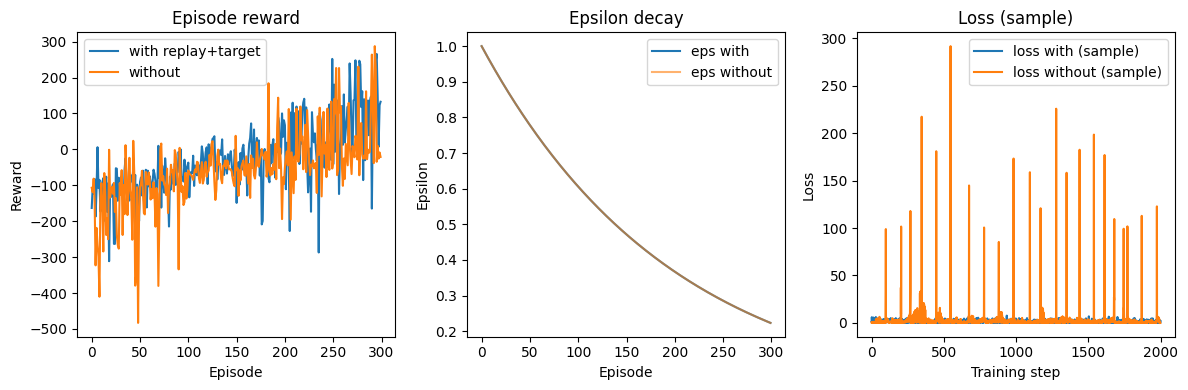

Avg last 50 (with): 86.76043899390314
Avg last 50 (without): 34.36788588064994
Saved: lunar_comparison.png


In [ ]:
# ---------- Run experiments: with replay+target and without ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

env_name = "LunarLander-v3"  # or "LunarLander-v2" if v3 not available
NUM_EPISODES = 300  # increase to 600–1000 for stronger learning

print("Running WITH replay + target (recommended)...")
res_with = train_lunarlander(env_name=env_name, num_episodes=NUM_EPISODES,
                             batch_size=64, gamma=0.99, lr=1e-3,
                             replay_capacity=30000, min_replay_size=1000,
                             target_update_steps=1000,
                             epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                             use_replay=True, use_target=True, device=device)

print("\nRunning WITHOUT replay & WITHOUT target (online updates)...")
res_without = train_lunarlander(env_name=env_name, num_episodes=NUM_EPISODES,
                                batch_size=64, gamma=0.99, lr=1e-3,
                                replay_capacity=30000, min_replay_size=0,
                                target_update_steps=999999999,  # effectively never update
                                epsilon_start=1.0, epsilon_end=0.05, epsilon_decay=0.995,
                                use_replay=False, use_target=False, device=device)

# ---------- Plot results ----------
plt.figure(figsize=(12,4))
plt.subplot(1,3,1)
plt.plot(res_with['rewards'], label='with replay+target')
plt.plot(res_without['rewards'], label='without')
plt.xlabel('Episode'); plt.ylabel('Reward'); plt.title('Episode reward')
plt.legend()

plt.subplot(1,3,2)
plt.plot(res_with['eps'], label='eps with')
plt.plot(res_without['eps'], label='eps without', alpha=0.6)
plt.xlabel('Episode'); plt.ylabel('Epsilon'); plt.title('Epsilon decay')
plt.legend()

plt.subplot(1,3,3)
if len(res_with['loss']) > 0:
    plt.plot(res_with['loss'][:2000], label='loss with (sample)')
if len(res_without['loss']) > 0:
    plt.plot(res_without['loss'][:2000], label='loss without (sample)')
plt.xlabel('Training step'); plt.ylabel('Loss'); plt.title('Loss (sample)')
plt.legend()

plt.tight_layout()
plt.savefig("lunar_comparison.png", dpi=150)
plt.show()

print("Avg last 50 (with):", np.mean(res_with['rewards'][-50:]))
print("Avg last 50 (without):", np.mean(res_without['rewards'][-50:]))
print("Saved: lunar_comparison.png")
